# Justin's Tools for Querying Calibration and Reference Star Targets
These tools utilize astroquery to query Simbad and VizieR (coming soon!) for collecting information for both specific targets and identifying possible targets that satisfy some sort of criteria.

First, import the relevant packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astroquery.simbad import Simbad
import time
import astropy.units as u
from astropy.coordinates import SkyCoord
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch,Rectangle
from astropy.coordinates import HeliocentricTrueEcliptic
from astropy.coordinates import HeliocentricMeanEcliptic
from astropy.coordinates import Galactic
from astropy.coordinates import ICRS
from astropy.time import Time as astroTime

Next, customize some of the Simbad query settings. Check out https://simbad.u-strasbg.fr/simbad/tap/tapsearch.html for a guide on all votable fields in astroquery Simbad queries.

In [2]:
simbad = Simbad()
simbad.add_votable_fields("pmra",
							"pmdec",
							"sp_type",
							"V",
							"G",
							"I",
							"H",
							"plx_value",
							"rvz_radvel")

# Tutorial for Identifying Candidate Targets based on a set of Selection Criteria

If you need to find targets that satisfy some sort of specific reference criteria, the easiest thing to do is to query the TAP service. To do this, you construct a string of your ADQL TAP query, and can then use astroquery's queryTap function to make the query. Using ADQL (Astronomy Data Query Language) allows you to specifically optimize your query.

Many of the Roman-Coronagraph calibration target criteria are related to target magnitudes, so let's construct a function that can query Simbad based off of some magnitude criteria. For Roman, we also want to avoid binaries/double stars to the best of our ability. We also want to avoid variable stars particularly if we want to identify potential flux standards. While variable stars come in many forms, it's easiest to just avoid any object that may be considered a variable star (and double stars) regardless of how much of an impact the properties may have on performing actual calibrations. In this next cell, I'll give the function I create that queries Simbad for targets based off the following criteria:

Has a V magnitude within a certain range of a target V magnitude

Is not classified as a variable star (V*) or a double star (**). ADQL queries are verbose, so I'll go through each line to explain what each step is doing.

In [3]:
def queryTap_byVmag(Vmag,cone=0.1):
    #"""
    #Queries Simbad using the ADQL TAP service for stars that are within a certain Vmag of Vmag and are not double and/or variable stars.
    #Inputs:
    #    Vmag: Target V magnitude you want to query for
    #    cone: (Default=0.1), cone in which magnitudes within Vmag+/-cone are acceptable to query
    #Returns:
    #    Simbad query result in the form of an astropy table. The columns of the table have the properties of each target, each row is an individual target from the query result.
    #"""
	example_base = """SELECT TOP 50 oid, main_id, ra, dec, pmra, pmdec, plx_value, rvz_radvel, otype, V, otypes
						FROM basic JOIN allfluxes ON basic.oid = allfluxes.oidref JOIN alltypes ON basic.oid = alltypes.oidref
						WHERE (otype = '*') AND (otype != 'V*..') AND (otype != '**..') AND (V <= {VmagUp}) AND (V >= {VmagDown})
						AND (otypes) NOT LIKE ('%V*%')
						AND (otypes) NOT LIKE ('%**%')
                        AND (otypes) NOT LIKE ('%**?%')
  						AND ra IS NOT NULL
  						AND dec IS NOT NULL
                        AND plx_value IS NOT NULL
                        AND pmra IS NOT NULL
                        AND pmdec IS NOT NULL
                        AND rvz_radvel IS NOT NULL
  						;"""
    #^This is the query string that will do everything! In the next markdown cell I'll break done each component and explain how it works
	example = example_base.format(VmagUp=str(Vmag+cone),VmagDown=str(Vmag-cone)) #This line takes your input Vmag and cone and converts the values into strings that are inserted in the query string.

	queryresult = simbad.query_tap(example) #This step performs the query!

	return queryresult #Return your query result

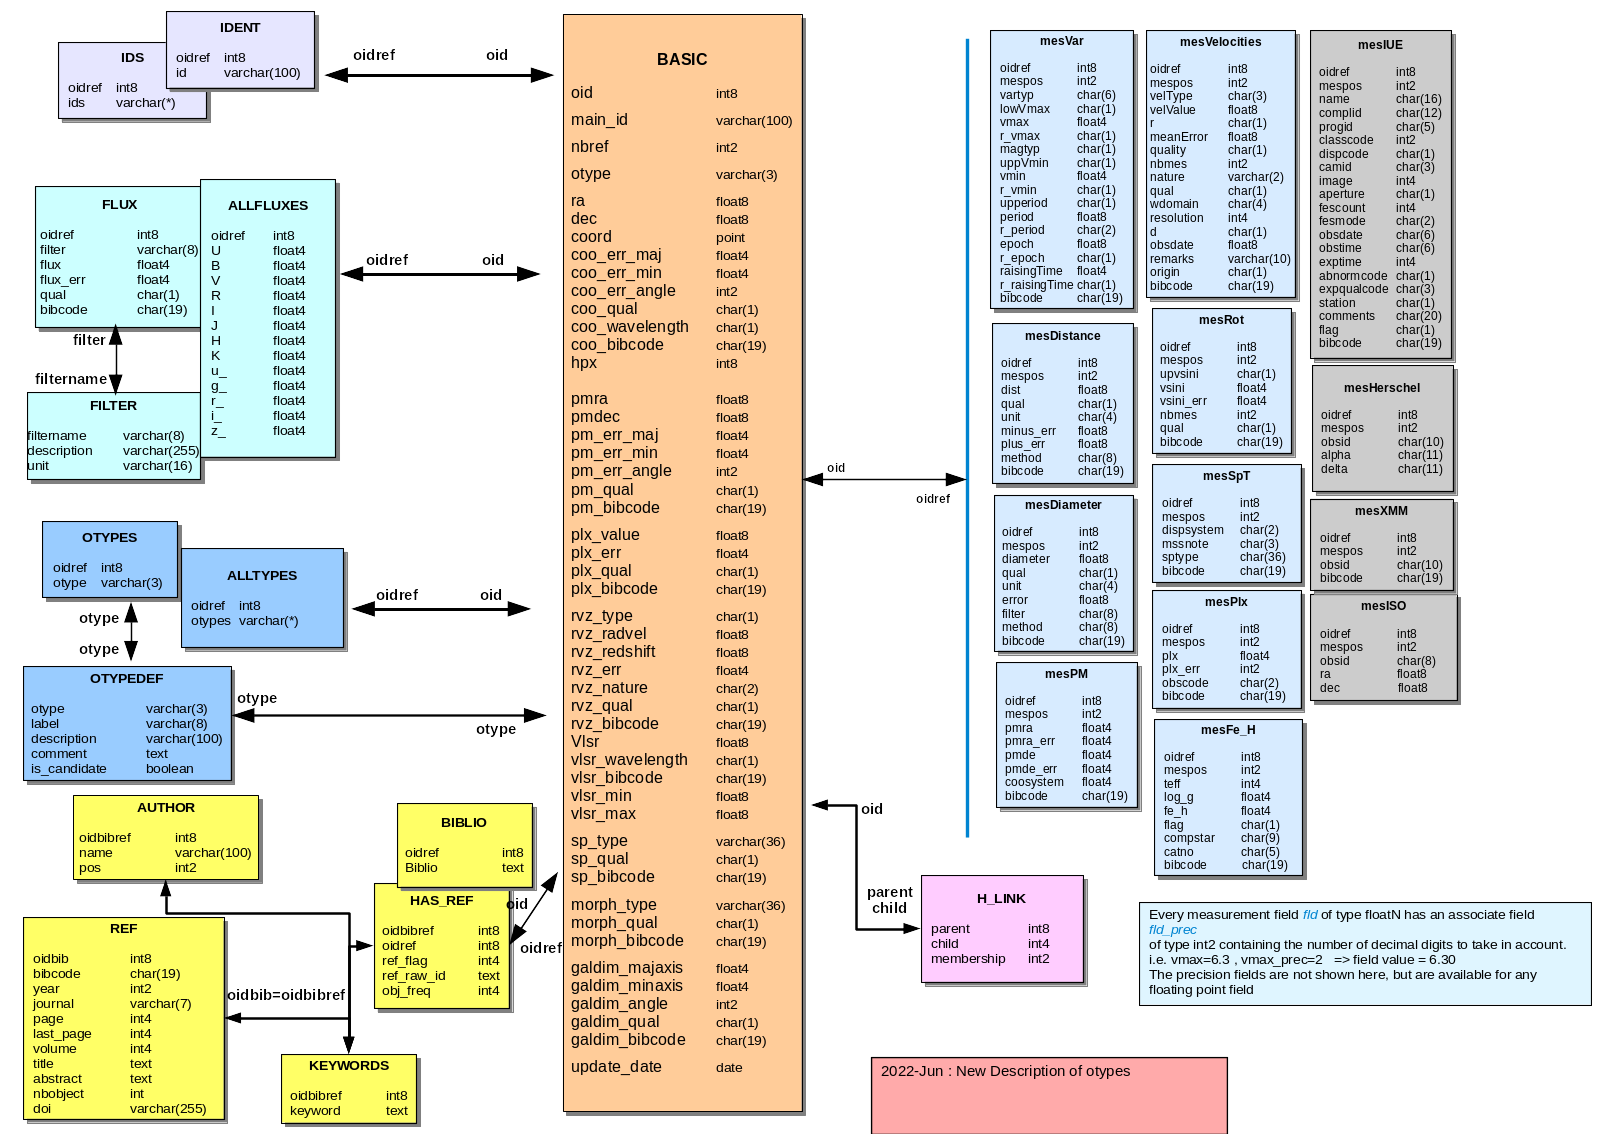

(image credit, Simbad website)
I'm going to break down each step/line of the query string so that it makes sense

**SELECT TOP 50** - This is a command saying to output up to 50 possible targets. Note that this is not sorted in some preferrential way... that involves some additional ADQL language.

**oid, main_id, ra, dec, pmra, pmdec, plx_value, rvz_radvel, otype, V, otypes** - These are the names of the columns or keywords you are querying, following the names described here: https://simbad.u-strasbg.fr/simbad/tap/tapsearch.html



If you follow the link (or view the chart above), you'll notice how keywords are categorized. By default, unless specified, you will only have access to the "BASIC" category of keywords. This means that unless you JOIN tables, trying to query keywords not in the BASIC table will cause your query to fail. In the above example, all of these keywords are in the "BASIC" table except for "otype," "V," and "otypes." Joining tables is the next line.

**FROM basic JOIN allfluxes ON basic.oid = allfluxes.oidref JOIN alltypes ON basic.oid = alltypes.oidref** - This line says to join multiple keyword tables together. You need to join each table separately.

"allfluxes" has the "V" keyword we want, so we JOIN allfluxes to basic. But how do we know how to link the two tables together? This is where ON comes in. The arrows linking the different keyword tables all have some common keyword that is common to both tables, but that keyword does not necessarily have the same name in each table. In the case of "allfluxes" and "basic", the "oid" keyword from "basic" is the same as the "oidref" keyword from "allfluxes." Therefore,

FROM basic JOIN allfluxes ON basic.oid = allfluxes.oidref

says to join "basic" and "allfluxes" by linking the basic.oid keyword to the allfluxes.oidref keyword. If we want to join multiple keyword tables to "basic," we repeat the commands with JOIN and ON again. So in this line, we're saying JOIN "allfluxes" to "basic" using the basic.oid keyword and allfluxes.oidref keyword and also JOIN "alltypes" to "basic" using the basic.oid and alltypes.oidref keywords

At this point, we have established what keywords (properties) we want to query. From this point onwards, we now input the query criteria, starting with "WHERE". Each criteria can only be described one at a time, and separated with "AND". In our example criteria:

**WHERE (otype = '*') AND** - We want (=) the object type to be a star, or "*"

**(otype != 'V(asterisk)..') AND** - We do not want (!=) to be the primary object type to be a variable star or "V*"

**(otype != '(asterisk)(asterisk)..') AND** - We do not want the primary object type to be a double star

**(V <= {VmagUp}) AND** - We want the object V magnitude to be lower than VmagUp, which is a customizable input

**(V >= {VmagDown}) AND** - We want the object V magnitude to be higher than Vmag Down, again a customizable input

**(otypes) NOT LIKE ('%V(asterisk)%') AND** - Just because we excluded objects where the primary type is a variable star, it doesn't mean we have excluded all variable stars. This means that in the list of other object types (otypes), we don't want 'V*' to show up there. This is denoted with % on either side to represent wildcards.

**(otypes) NOT LIKE ('%(asterisk)(asterisk)%') AND** - Same with the double stars.

**ra IS NOT NULL AND** - make sure there are actually coordinates

**dec IS NOT NULL;**

This page that describes the abbreviations for different Simbad otypes is also useful: https://simbad.cds.unistra.fr/guide/otypes.htx

And that's it! Let's try it out.

In [5]:
queryTap_byVmag(7.51,cone=0.1)

oid,main_id,ra,dec,pmra,pmdec,plx_value,rvz_radvel,otype,V,otypes
,,deg,deg,mas / yr,mas / yr,mas,km / s,,,
int64,object,float64,float64,float64,float64,float64,float64,object,float64,object
132295,HD 4404,11.78956456555,60.26730459564,8.618,1.252,1.4304,-20.82,*,7.519999980926514,*|IR|NIR
242642,HD 18876,46.31737780979,63.02943581568,0.381,-9.878,2.4136,-5.0,*,7.505000114440918,*|NIR|UV
2808126,HD 189731,300.16125891777,24.149178666460003,2.195,-9.452,1.8233,-18.83,*,7.53000020980835,*|IR|NIR
2926680,HD 186200,295.34676225888995,38.45796171104,0.03,-3.006,0.9183,17.2724,*,7.519999980926514,*|NIR|UV
1526887,HD 212942,336.83552532219,33.51435698965,6.748,-26.665,11.5681,1.24,*,7.559999942779541,*|NIR
154238,HD 196905,309.53039191242993,52.006591438559994,-17.631,-3.654,2.7999,1.02,*,7.440000057220459,*|IR|NIR
1785079,HD 97005,167.58755797003,22.7019355241,16.046,-5.004,5.9799,-18.03,*,7.480000019073486,*|NIR|UV
1680959,HD 87659,151.46855917424,-27.27505866065,-28.923,26.482,3.0906,23.47,*,7.480000019073486,*|IR|NIR


So we have our astropy table now of 50 targets that satisfy our selection criteria. Note that if you run this query again, you may not get the exact same 50 targets as before. This is because the TAP query is just identifying from its database a set of 50 targets that **exactly** satisfy the criteria you gave it, and as soon as it finds 50, it stops. Therefore, if there are more than 50 targets that satisfy the criteria, you may get different results every time you perform a query.

# Creating Sky Coverage Maps

Now let's use our query function and create a sky coverage map of the targets we found. We can do this by using astropy's SkyCoord class.

Now, we don't just want to take our ICRS J2000 coordinates and plot them on the sky. In the case of the Roman-Coronagraph, knowing to high accuracy where are targets are in the sky matters a lot for scheduling. Therefore, understanding where our targets will be in the year 2027 means we should account for target proper motion. We also care about the locations of targets with respect to Roman's Continuous Viewing Zone (CVZ), as targets in this region are much easier to schedule. We can use Heliocentric Mean Ecliptic coordinates to approximate the CVZ as cones 36 degrees in size from the Ecliptic poles. In reality, the true coordinates are dependent on the reference frame of the observatory itself, but for now, Heliocentric Mean Ecliptic is a good approximation.

Let's create a sky coverage map for targets that can be used for Image Correction calibrations. This is a set of 4 targets at different magnitudes each that help calibrate gain factors of the EMCCD detector.

Now let's query Simbad based off of our target magnitudes.

Completed Mag 5.5
Completed Mag 8.5
Completed Mag 11.5
Completed Mag 13.5


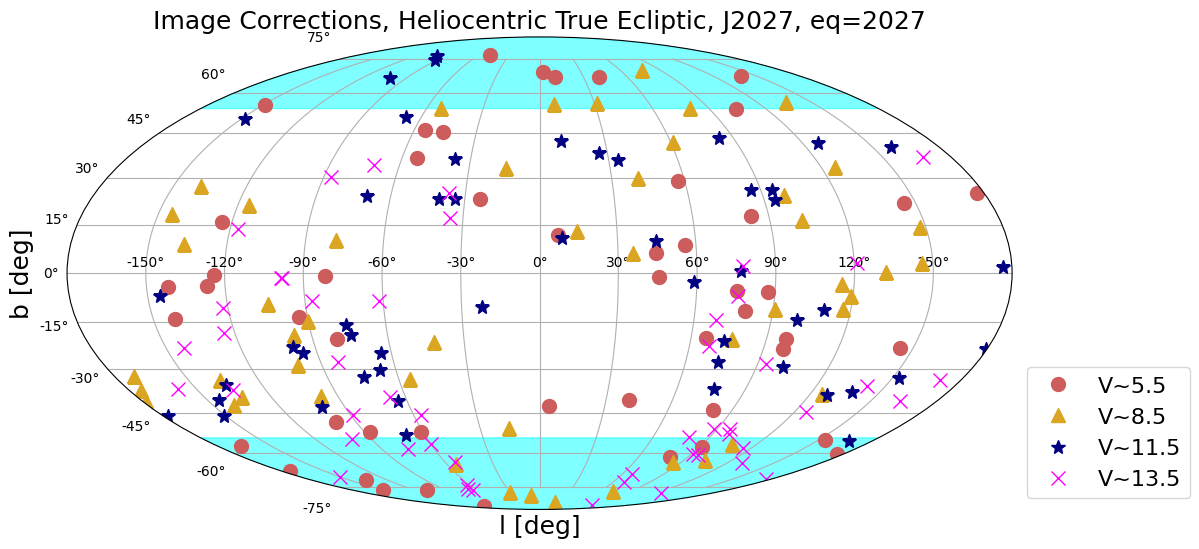

In [6]:
magList = np.array([5.5,8.5,11.5,13.5]) #Array of V magnitudes that we want to query
markers_arr = ['o','^','*','x'] #Plot markers for the sky map
markers_col = ['indianred','goldenrod','navy','magenta'] #Marker colors for plotted points
#Setting up the plot
fig1,ax1 = plt.subplots(1,1,figsize=(12,6),subplot_kw={'projection': 'mollweide'}) #This creates a Mollweide projection map
ax1.grid(True) #Grid lines
ax1.axhspan(np.deg2rad(54), np.deg2rad(90), alpha=0.5, color='cyan') #Plot out CVZs as a shaded region
ax1.axhspan(np.deg2rad(-90), np.deg2rad(-54), alpha=0.5, color='cyan')
ax1.set_title('Image Corrections, Heliocentric True Ecliptic, J2027, eq=2027',fontsize=18) #Set a plot title
ax1.set_xlabel('l [deg]',fontsize=18) #Set axes labels
ax1.set_ylabel('b [deg]',fontsize=18)
for i in np.arange(len(magList)):
    mag = queryTap_byVmag(magList[i],cone=0.05)
    #The following lines fill any missing values in your table query with the numbers in parentheses
    #mag["plx_value"] = mag["plx_value"].filled(0.00001)
    #mag["pmra"] = mag["pmra"].filled(0.0)
    #mag["pmdec"] = mag["pmdec"].filled(0.0)
    #mag["rvz_radvel"] = mag["rvz_radvel"].filled(0.0)
    magDist = 1000./mag["plx_value"].value #Calculate the system distance in pc

    epochtime = astroTime('J2027',format='jyear_str') #Define epoch and equinox times for the ecliptic transformation
    equitime = astroTime(2027.0,format='decimalyear')

    ics = SkyCoord(ra=mag['ra'],dec=mag['dec'],unit=(u.deg,u.deg),frame='icrs',
		distance=magDist*u.pc,pm_ra_cosdec=mag["pmra"],pm_dec=mag["pmdec"],
		radial_velocity=mag["rvz_radvel"],obstime=astroTime('J2000',format='jyear_str')) #Set up a SkyCoord object. Requires the values from Simbad Query.

    newICS = ics.apply_space_motion(new_obstime=epochtime) #Apply proper and radial motion to the new observing time of 2027

    newECL = newICS.transform_to(HeliocentricTrueEcliptic(equinox=astroTime(2027.0,format='decimalyear'),obstime=astroTime('J2027',format='jyear_str'))) #Transform your proper motion applied ICRS coordinates to ecliptic coordinates

    ra_rad = newECL.lon.wrap_at(180 * u.deg).radian #Express your ecliptic coordinates (longitude and latitude) in radians for plotting, allow it to wrap around the projection to the other side
    dec_rad = newECL.lat.radian

    #Plot your result
    ax1.plot(ra_rad,dec_rad,marker=markers_arr[i],linestyle='None',color=markers_col[i],markersize=10,label='V~'+str(magList[i]))

    time.sleep(5) #I put this step in because if you make too many simbad queries in a given time interval, your IP gets blocked for a period of time. So every time you complete a query, wait 5 seconds before starting the next one.
    print('Completed Mag '+str(magList[i]))
#Create a plot legend
ax1.legend(bbox_to_anchor=(1.2,0),loc='lower right',fontsize=16)
fig1.tight_layout() #Clean it up
plt.show()


There you have it! You created a sky coverage map of possible image correction calibration targets that satisfy the criteria of having a certain V magnitude, having proper motions and radial velocities, and not being variable and/or double stars. TAP queries are verbose, but the verbosity helps to convey what criteria you're actually filtering for when performing a query. Stay tuned for other additions to this tutorial including querying for objects within a certain coordinate region and also querying VizieR catalogs.

# Pre-Built Functions

The python script CalWG_Targets.py has pre-built functions to query and catalog targets for all Roman-Coronagraph calibration types (except for planetary flat fields Uranus and Neptune). I will call each of the functions below in case you just want to quickly identify possible calibration targets. If you are interested in understanding how these functions work, you can look at CalWG_Targets.py, although much of it just follows the tutorial outlined above but for specific calibration target criteria.

In [7]:
from CalWG_Targets import *

Could not import regions, which is required for some of the functionalities of this module.


# Absolute Flux Calibration

The absolute flux calibration function queries Simbad for specific target names. These targets were identified as absolute flux standards from HST calibration target lists. They were preferentially selected to be in the CVZ, and are outlined in [Payne et al. (2022), Proc. SPIE, Vol. 12188, ID 121884GP](https://ui.adsabs.harvard.edu/abs/2022SPIE12188E..4GP/abstract). They include a collection of both bright and faint standards. The only inputs are keywords "catsave" and "plotsave" for saving queries to a csv and saving the sky coverage map as a jpg respectively.

Bright Standards:

109 Vir

alf Lyr

eta UMa

ksi02 Cet


Faint Standards:

2MASS J18083474+6927286

2MASS J18120957+6329423

2MASS J17571324+6703409

2MASS J18052927+6427520

2MASS J14515797+7143173

2MASS J17551622+6610116

2MASS J18022716+6043356

2MASS J17325264+7104431

2MASS J16313382+3008465

2MASS J17403468+6527148

/Users/jrhom/anaconda3/envs/Disk_ETCsSep24/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 4 of "solution didn't converge (Note 8)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


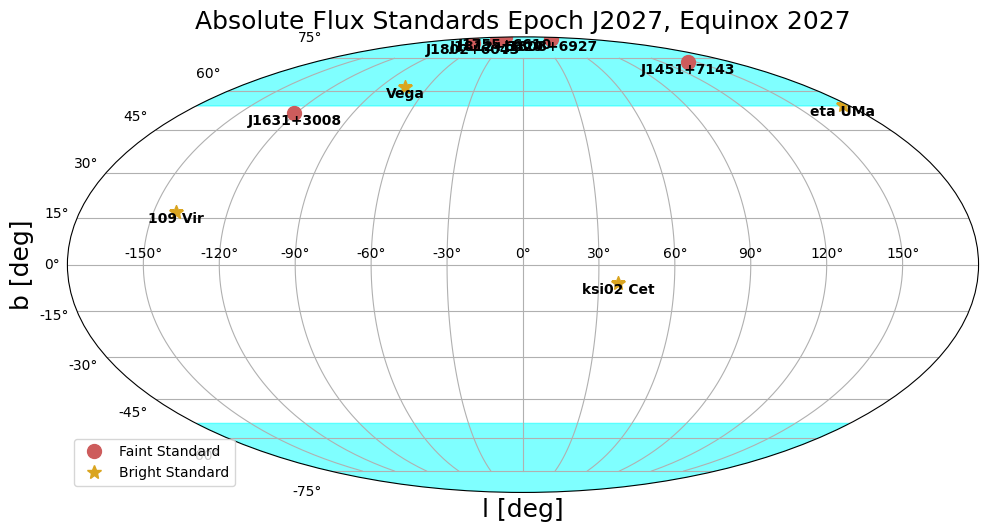

In [8]:
absFluxCoverage(catsave=False,plotsave=False)

# Core Throughput Standards

The Roman-Coronagraph criteria for core throughput standards are that it must have a V magnitude fainter than 10.9. The coreThruput() function in CalWG_Targets.py queries Simbad for targets that have a V magnitude ranging from 10.9 to 12.0. Again, the only keywords here are 'catsave' and 'plotsave' which serve the same function as before.

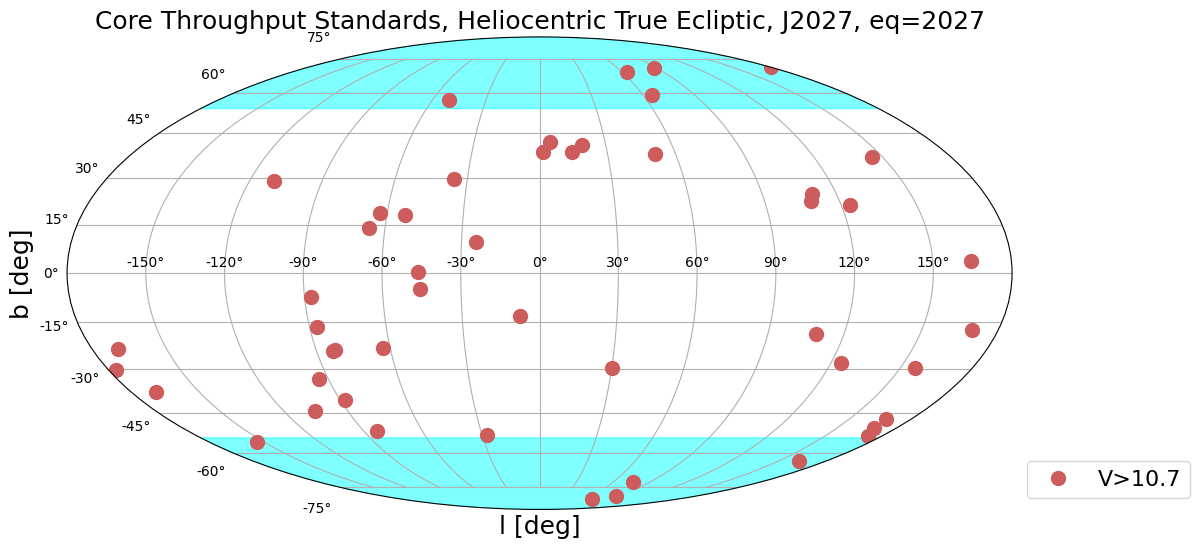

In [9]:
coreThruput(catsave=False,plotsave=False)

# Commissioning Flats

The nominal plan for flat field calibrations are raster scanned observations of Uranus and Neptune. These are very difficult to schedule, as Roman does not have nonsidereal tracking. As a backup plan, commissioning flats will involve rastering of a V~8.55 magnitude star. The same keywords of 'catsave' and 'plotsave' are used here again.

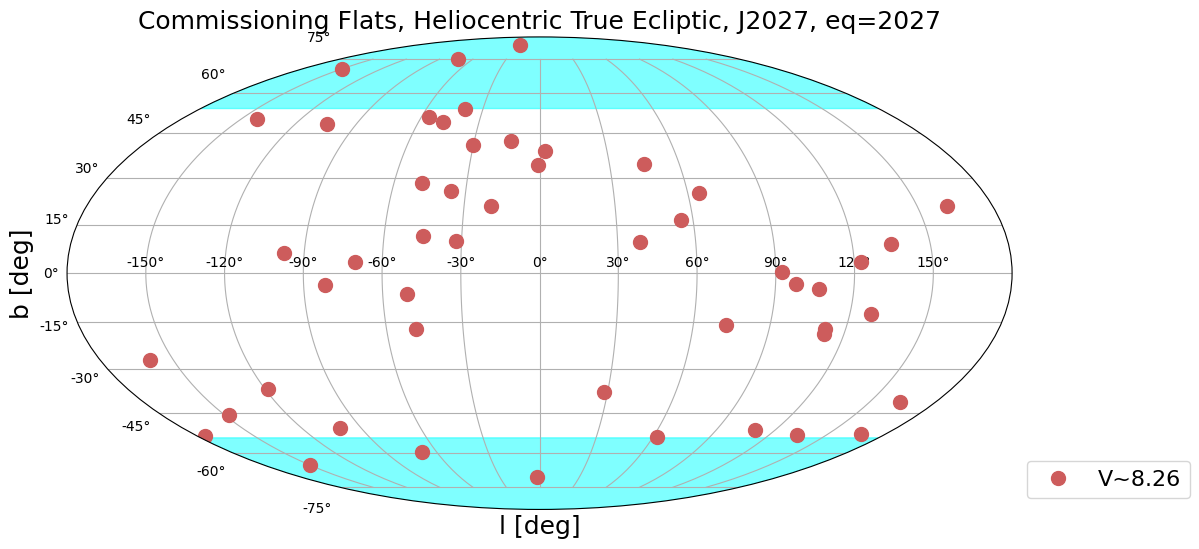

In [10]:
commissioningFlats(catsave=False,plotsave=False)

# Image Corrections

Stars of varying brightnesses are needed to calibrate gain factors for the Roman-Coronagraph detector. Specifically, magnitudes 5.5, 8.5, 11.5, and 13.5 are needed. Again, the 'catsave' and 'plotsave' here have their same functions as before.

  oid     main_id           ra         ...         H                  K         
                           deg         ...                                      
------- ----------- ------------------ ... ------------------ ------------------
2311628 * phi02 Lup  230.7889609843454 ... 4.9670000076293945  4.942999839782715
 897197   * lam CMa  97.04253341978293 ...  5.008999824523926  4.908999919891357
3525685   * sig Ara  263.9149639867754 ... 4.6579999923706055 4.4720001220703125
1295423   *   2 Cet 0.9349492958375001 ...  4.610000133514404  4.564000129699707
1829890   * ups Leo 174.23721152069376 ... 2.0999999046325684  2.009999990463257
3214546   * mu. Phe 10.331547459460834 ...  2.450000047683716 2.8499999046325684
1426711 * ksi02 Cet   37.0398210789746 ...  4.380000114440918  4.392000198364258
 786917     * e Ori   80.9867824417454 ... 2.0320000648498535 1.9249999523162842
1662457 * ups01 Hya 147.86947907884206 ...  2.109999895095825 2.0299999713897705
    ...         ...         

Completed Mag 7.5
  oid       main_id     ...         H                  K         
                        ...                                      
------- --------------- ... ------------------ ------------------
2777770     BD+21  2856 ...  8.144000053405762  8.048999786376953
1428017     BD+09  4837 ...  7.334000110626221  7.243000030517578
1580218     BD+36   403 ...  6.320000171661377 6.1579999923706055
1921311       HD 106935 ...  7.191999912261963  7.054999828338623
 221253     BD+68  1339 ...  8.434000015258789  8.343000411987305
2672348     BD+03  3840 ...  8.479999542236328  8.463000297546387
2595249       HD 144743 ... 6.2270002365112305  6.061999797821045
 379662  TYC 4552-530-1 ...  8.515999794006348  8.435999870300293
 729805       HD  28895 ... 7.2129998207092285  7.052000045776367
    ...             ... ...                ...                ...
1796607     CD-32  7930 ...  8.434000015258789   8.38599967956543
3381032       HD 133763 ...  6.191999912261963  5.98699998

Completed Mag 9.7
  oid        main_id      ...         H                  K         
                          ...                                      
-------- ---------------- ... ------------------ ------------------
 6892713  TYC 3605-1607-1 ... 10.265000343322754  10.20199966430664
 7118570   TYC 5290-170-1 ... 10.645000457763672 10.548999786376953
 7285694  TYC 6548-3258-1 ...  9.145999908447266  8.928000450134277
 8865801  UCAC2  32305237 ... 11.418000221252441 10.050999641418457
 7447955  TYC 7691-4080-1 ...  10.76200008392334 10.675999641418457
 7068428   TYC 4806-602-1 ...  8.956000328063965  8.805999755859375
 7453228   TYC 7715-614-1 ... 10.473999977111816 10.390000343322754
 6445494  TYC  632-1190-1 ...  9.744999885559082  9.661999702453613
 6378122   TYC   89-823-1 ... 10.864999771118164 10.847000122070312
     ...              ... ...                ...                ...
25144419 UCAC4 442-044276 ...  9.437999725341797  9.319999694824219
 6965920    TYC 4013-19-1 ... 

Completed Mag 11.8


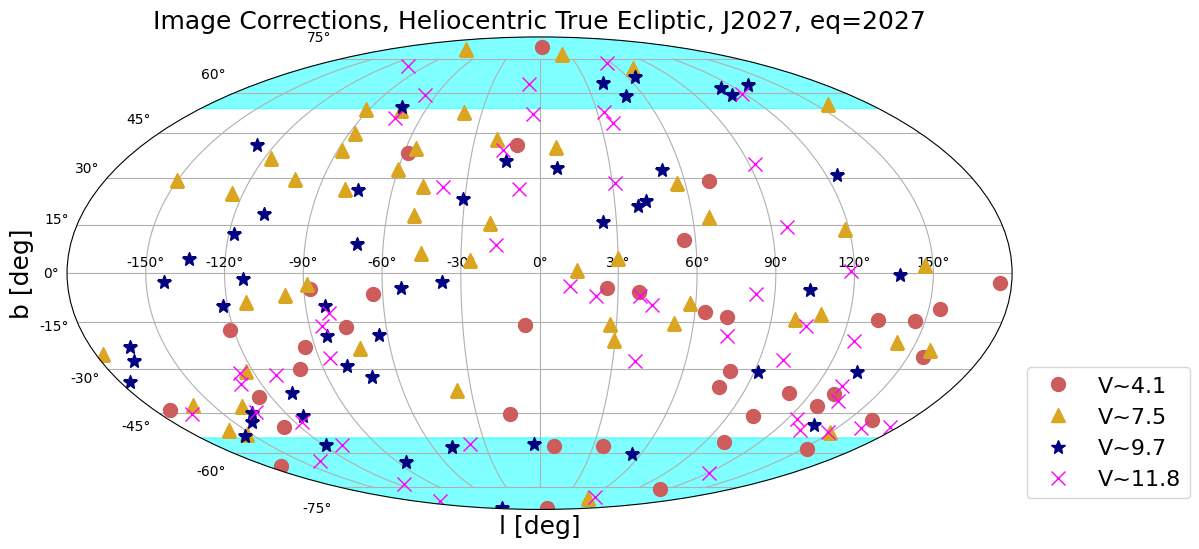

In [11]:
imageCorrections(catsave=False,plotsave=False)

# Built-In Function to Query Gaia and VizieR Catalogs

This function performs queries of Simbad, Gaia, and various VizieR catalogs to populate database-relevant information. First, define the calibration target type to build off of. This assumes that you have a list of targets to consider in a csv file, with at least 1 column named "main_id" that has Simbad-queryable target names. In the example below, you need to have a csv file in your working directory called 'AbsoluteFluxStandards.csv'

The query will grab all coordinate, magnitude, spectral type, object type, id, and motion properties from Simbad first. Then, it queries Gaia DR3 and Gaia DR2 for additional coordinate, Gaia G mag, proper motion, parallax, and RUWE information. It will then query the JSDC and JMMC VizieR catalogs to gather stellar diameter information. Finally, it will query Kervella et al. 2019 and 2022 for proper motion anomaly information.

Warning: Running this function takes a long time. This is because you can only query one target at a time one catalog at a time. Additionally, there are 1 second pauses after each query, because if you query CDS Simbad/VizieR too many times too quickly, your IP gets firewalled for a period of time. Gaia queries do not have this issue, as Gaia queries are submitted asynchronously.

In [12]:
CatalogBuild('AbsoluteFluxStandards')

    Unnamed: 0            main_id          ra        dec  coo_err_maj  \
0            0    TYC 4433-1800-1  272.144733  69.457978     0.016500   
1            1    TYC 4205-1677-1  273.039864  63.495073     0.014900   
2            2     TYC 4212-455-1  269.305134  67.061321     0.032200   
3            3    TYC 4209-1396-1  271.371982  64.464477     0.022000   
4            4     TYC 4413-304-1  222.991581  71.721498     0.012700   
5            5    UCAC3 313-62260  268.817566  66.169891     0.010700   
6            6  BPS BS 17447-0067  270.613202  60.726553     0.019400   
7            7    TYC 4424-1286-1  263.219291  71.078645     0.016800   
8            8    GSC 02581-02323  247.890885  30.146221     0.007600   
9            9     TYC 4207-219-1  265.144495  65.454106     0.020100   
10          10          * 109 Vir  221.562181   1.892884     0.220200   
11          11          * alf Lyr  279.234735  38.783689     3.511180   
12          12          * eta UMa  206.885157  49.3

 oid      main_id     ...         H                  K         
                      ...                                      
------ -------------- ... ------------------ ------------------
326750 TYC 4212-455-1 ... 11.218999862670898 11.154999732971191
Gaia DR3 1633585107317144960
INFO: Query finished. [astroquery.utils.tap.core]
Gaia DR2 1633585107317144960
INFO: Query finished. [astroquery.utils.tap.core]


 oid       main_id     ...         H                  K         
                       ...                                      
------ --------------- ... ------------------ ------------------
312424 TYC 4209-1396-1 ... 12.031000137329102 12.005000114440918
Gaia DR3 2161093682102883712
INFO: Query finished. [astroquery.utils.tap.core]
Gaia DR2 2161093682102883712
INFO: Query finished. [astroquery.utils.tap.core]


  oid      main_id     ...         H                  K         
                       ...                                      
------- -------------- ... ------------------ ------------------
5415848 TYC 4413-304-1 ... 10.592000007629395 10.526000022888184
Gaia DR3 1698468284904574208
INFO: Query finished. [astroquery.utils.tap.core]
Gaia DR2 1698468284904574208
INFO: Query finished. [astroquery.utils.tap.core]


 oid       main_id     ...         H                 K         
                       ...                                     
------ --------------- ... ----------------- ------------------
326742 UCAC3 313-62260 ... 11.09000015258789 10.987000465393066
Gaia DR3 1633294634388508416
INFO: Query finished. [astroquery.utils.tap.core]
Gaia DR2 1633294634388508416
INFO: Query finished. [astroquery.utils.tap.core]


 oid        main_id      ...         H                  K         
                         ...                                      
------ ----------------- ... ------------------ ------------------
311236 BPS BS 17447-0067 ... 11.850000381469727 11.831999778747559
Gaia DR3 2158745262705810304
INFO: Query finished. [astroquery.utils.tap.core]
Gaia DR2 2158745258408552064
INFO: Query finished. [astroquery.utils.tap.core]


 oid       main_id     ...         H                  K         
                       ...                                      
------ --------------- ... ------------------ ------------------
328415 TYC 4424-1286-1 ... 12.255000114440918 12.253999710083008
Gaia DR3 1651137131123978112
INFO: Query finished. [astroquery.utils.tap.core]
Gaia DR2 1651137131123978112
INFO: Query finished. [astroquery.utils.tap.core]


  oid       main_id     ...         H                  K         
                        ...                                      
------- --------------- ... ------------------ ------------------
2835011 GSC 02581-02323 ... 11.454000473022461 11.378999710083008
Gaia DR3 1312054926303736704
INFO: Query finished. [astroquery.utils.tap.core]
Gaia DR2 1312054926303736704
INFO: Query finished. [astroquery.utils.tap.core]


 oid      main_id     ...         H                  K         
                      ...                                      
------ -------------- ... ------------------ ------------------
326748 TYC 4207-219-1 ... 12.022000312805176 11.996000289916992
Gaia DR3 1633143932573832448
INFO: Query finished. [astroquery.utils.tap.core]
Gaia DR2 1633143932573832448
INFO: Query finished. [astroquery.utils.tap.core]


  oid    main_id  ...         H                 K         
                  ...                                     
------- --------- ... ----------------- ------------------
2289727 * 109 Vir ... 3.628000020980835 3.6459999084472656
Gaia DR3 3655377057091634304
INFO: Query finished. [astroquery.utils.tap.core]
Gaia DR2 3655377057091401856
INFO: Query finished. [astroquery.utils.tap.core]
K22 Query Successful
Adding in K22
 HIP    RUWE     dVt       e_dVt    dVtPA  e_dVtPA
                m / s      m / s     deg     deg  
----- ------- ---------- ---------- ------ -------
72220   0.923     424.39     190.10  12.80   13.96
K19 Query Successful
Adding in K19


  oid    main_id  ...           H                   K         
                  ...                                         
------- --------- ... --------------------- ------------------
2900336 * alf Lyr ... -0.028999999165534973 0.1289999932050705
Both UD and LD meas available
JMMC Query Successful
Adding in JMMC


 oid    main_id  ...         H                  K        
                 ...                                     
------ --------- ... ------------------ -----------------
566010 * eta UMa ... 2.4079999923706055 2.265000104904175
Gaia DR3 1510374147844219904
INFO: Query finished. [astroquery.utils.tap.core]
Both UD and LD meas available
JMMC Query Successful
Adding in JMMC
K22 Query Successful
Adding in K22


  oid     main_id   ...         H                 K        
                    ...                                    
------- ----------- ... ----------------- -----------------
1426711 * ksi02 Cet ... 4.380000114440918 4.392000198364258
Gaia DR3 22745910577134848
INFO: Query finished. [astroquery.utils.tap.core]
Gaia DR2 22745910577134848
INFO: Query finished. [astroquery.utils.tap.core]
Both UD and LD meas available
JMMC Query Successful
Adding in JMMC
K22 Query Successful
Adding in K22
 HIP    RUWE     dVt       e_dVt    dVtPA  e_dVtPA
                m / s      m / s     deg     deg  
----- ------- ---------- ---------- ------ -------
11484   1.102    4432.13     354.89 279.11    3.12
K19 Query Successful
Adding in K19
  oid        main_id      ...     UDDmeas_ref         LDDmeas_ref    
                          ...                                        
------- ----------------- ... ------------------- -------------------
 314703   TYC 4433-1800-1 ...                  --      

# EXCAM Pointing Acquisition Check

This built-in function performs Gaia coordinate cone queries to check if a given target passes the EXCAM acquisition requirement. For a target with magnitude V, no target V+3 or brighter can be within 12".

After querying Gaia, a new version of the catalog is saved with a column denoting whether or not the candidate passed EXCAM acquisition. This function relies on you having a saved catalog as created by the previous function and has a specific naming convention. For example, for AbsoluteFluxStandards, you need a csv called 'AbsoluteFluxStandards_v2.csv' in your current working directory.

In [13]:
EXCAM_Standards('AbsoluteFluxStandards')

Checking  TYC 4433-1800-1
INFO: Query finished. [astroquery.utils.tap.core]
phot_g_mean_mag
      mag      
---------------
      12.040052
Completed  TYC 4433-1800-1
Checking  TYC 4205-1677-1
INFO: Query finished. [astroquery.utils.tap.core]
phot_g_mean_mag
      mag      
---------------
      11.716632
Completed  TYC 4205-1677-1
Checking  TYC 4212-455-1
INFO: Query finished. [astroquery.utils.tap.core]
phot_g_mean_mag
      mag      
---------------
      11.766908
Completed  TYC 4212-455-1
Checking  TYC 4209-1396-1
INFO: Query finished. [astroquery.utils.tap.core]
phot_g_mean_mag
      mag      
---------------
       12.28695
      18.164494
Catalog G:  12.28695
Completed  TYC 4209-1396-1
Checking  TYC 4413-304-1
INFO: Query finished. [astroquery.utils.tap.core]
phot_g_mean_mag
      mag      
---------------
     11.8707485
Completed  TYC 4413-304-1
Checking  UCAC3 313-62260
INFO: Query finished. [astroquery.utils.tap.core]
phot_g_mean_mag
      mag      
---------------
      13

# Plotting a Filtered Version of Your Catalog

Once you have all the catalog columns, you can now apply filtering to identify the targets that seem the most promising. For this example, I will load in the current candidates for Image Corrections, from a catalog called 'ImageCorrections_EXCAMv2.csv'. I will filter out any targets that both fail EXCAM acquisition (EXCAM_PASS = False) and have Gaia DR3 RUWE > 1.4. The function will tell you how many candidates satisfy your filtering. It will also identify the number of and names of candidates in the CVZ of Roman.

CVZ Targets after RUWE Filtering: 32 Stars
['* kap Eri', '* lam CMa', '* del Dor', '* N Car', 'HD 139607', 'HD 192660', 'HD  37719', 'HD 159887', 'HD 215855', 'HD  38243', 'HD  30062', 'HD 201397', 'IRAS 22311+5722', 'BD+41  2813', 'BD+69   667', 'HD 311137', 'CD-38  1736', 'BD+74  1020', 'HD  71165', 'CD-45  1459', 'CD-34  3626', 'BD+78   307', 'TYC 4489-87-1', 'TYC 4382-941-1', 'TYC 9388-634-1', 'TYC 4010-1696-1', 'TYC 3166-364-1', 'TYC 9225-632-1', 'TYC 4496-150-1', 'TYC 3491-646-1', 'TYC 7657-18-1', 'TYC 2634-622-1']
Image Corrections Candidates After EXCAM and RUWE Filtering
V=4-4.5:  13
V=7.5:  43
V=9.7:  43
V=11.8:  40


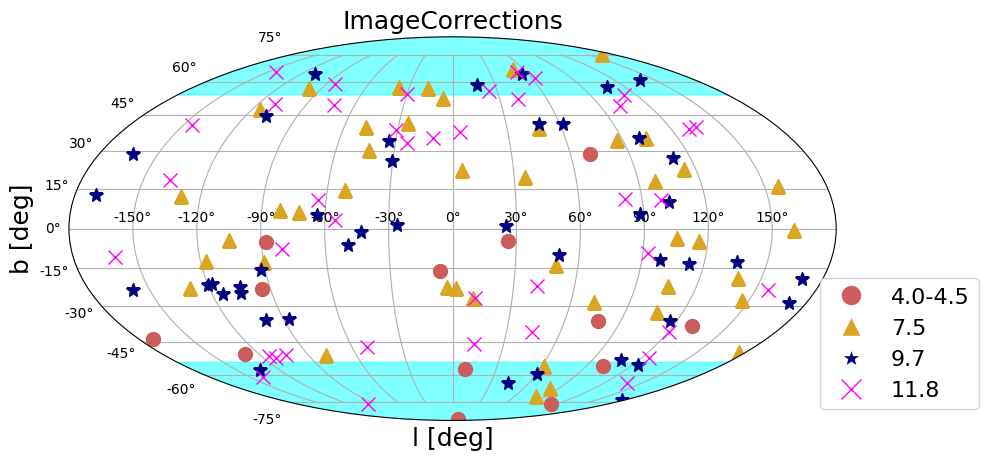

In [14]:
plotStandards_Saved('ImageCorrections',plotsave=False)